In [1]:
# It will download PascalVOC dataset (400Mo) and 
# pre-computed representations of images (450Mo)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

import tarfile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


URL_VOC = ("http://host.robots.ox.ac.uk/pascal/VOC/"
           "voc2007/VOCtrainval_06-Nov-2007.tar")
FILE_VOC = "VOCtrainval_06-Nov-2007.tar"
FOLDER_VOC = "VOCdevkit"

if not op.exists(FILE_VOC):
    print('Downloading from %s to %s...' % (URL_VOC, FILE_VOC))
    urlretrieve(URL_VOC, './' + FILE_VOC)

if not op.exists(FOLDER_VOC):
    print('Extracting %s...' % FILE_VOC)
    tar = tarfile.open(FILE_VOC)
    tar.extractall()
    tar.close()

URL_REPRESENTATIONS = ("https://github.com/m2dsupsdlclass/lectures-labs/"
                       "releases/download/0.2/voc_representations.h5")
FILE_REPRESENTATIONS = "voc_representations.h5"

if not op.exists(FILE_REPRESENTATIONS):
    print('Downloading from %s to %s...'
          % (URL_REPRESENTATIONS, FILE_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, './' + FILE_REPRESENTATIONS)

In [2]:
from __future__ import division
import numpy as np
import xml.etree.ElementTree as etree
import os
import os.path as op

# Parse the xml annotation file and retrieve the path to each image,
# its size and annotations
def extract_xml_annotation(filename):
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(z.find(".//width").text), int(z.find(".//height").text))
    fname = z.find("./filename").text
    dicts = [{obj.find("name").text:[int(obj.find("bndbox/xmin").text), 
                                     int(obj.find("bndbox/ymin").text), 
                                     int(obj.find("bndbox/xmax").text), 
                                     int(obj.find("bndbox/ymax").text)]} 
             for obj in objects]
    return {"size": size, "filename": fname, "objects": dicts}

In [3]:
# Filters annotations keeping only those we are interested in
# We only keep images in which there is a single item
annotations = []

filters = ["dog", "cat", "bus", "car", "aeroplane"]
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

annotation_folder = "VOCdevkit/VOC2007/Annotations/"
for filename in sorted(os.listdir(annotation_folder)):
    annotation = extract_xml_annotation(op.join(annotation_folder, filename))

    new_objects = []
    for obj in annotation["objects"]:
        # keep only labels we're interested in
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)

    # Keep only if there's a single object in the image
    if len(new_objects) == 1:
        annotation["class"] = list(new_objects[0].keys())[0]
        annotation["bbox"] = list(new_objects[0].values())[0]
        annotation.pop("objects")
        annotations.append(annotation)

In [4]:
print("Number of images with annotations:", len(annotations))

Number of images with annotations: 1264


In [5]:
print("Contents of annotation[0]:\n", annotations[0])

Contents of annotation[0]:
 {'size': (500, 333), 'class': 'car', 'bbox': [141, 50, 500, 330], 'filename': '000007.jpg'}


In [6]:
print("Correspondence between indices and labels:\n", idx2labels)

Correspondence between indices and labels:
 {0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}


## Pre-computing representations

Before designing the object detection model itself, we will pre-process all the dataset to project the images as spatial maps in a `(7, 7, 2048)` dimensional space once and for all. The goal is to avoid repeateadly processing the data from the original images when training the top layers of the detection network.


**Exercise**: Load a headless pre-trained `ResNet50` model from Keras and all the layers after the `AveragePooling2D` layer (included):

In [7]:
# TODO

headless_conv = None

In [8]:
# %load and create headless_conv model to extract the conv features
from keras.applications.resnet50 import ResNet50
from keras.models import Model

model = ResNet50(include_top=False)
input = model.layers[0].input

# Remove the average pooling layer
output = model.layers[-2].output
headless_conv = Model(input=input, output=output)


Using TensorFlow backend.


### Predicting on a batch of images

The `predict_batch` function is defined as follows:
- open each image, and resize them to `img_size`
- stack them as a batch tensor of shape `(batch, img_size_x, img_size_y, 3)`
- preprocess the batch and make a forward pass with the model

In [9]:
from scipy.misc import imread, imresize
from keras.applications.imagenet_utils import preprocess_input

def predict_batch(model, img_batch_path, img_size=None):
    img_list = []

    for im_path in img_batch_path:
        img = imread(im_path)
        if img_size:
            img = imresize(img,img_size)

        img = img.astype('float32')
        img_list.append(img)
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError(
            'when both img_size and crop_size are None, all images '
            'in image_paths must have the same shapes.')

    return model.predict(preprocess_input(img_batch))

Let's test our model:

In [11]:
output = predict_batch(headless_conv, ["dog.jpg"], (224, 224))
print("output shape", output.shape)

output shape (1, 7, 7, 2048)


The output size is `(batch_size, 224/32 = 7, 224/32 = 7, 2048)`

### Compute representations on all images in our annotations

Computing representations for all images may take some time (especially without a GPU), so it was pre-computed and save in `voc_representaions.h5`

This was achieved through the `compute_representations.py` script, you're welcome to use it if needed.

Otherwise, load the pre-trained representations in h5 format using the following:

In [12]:
import h5py

# Load pre-calculated representations
h5f = h5py.File('voc_representations.h5','r')
reprs = h5f['reprs'][:]
h5f.close()

In [13]:
print(reprs[0].shape)

(7, 7, 2048)


## Building ground truth from annotation

We cannot use directly the annotation dictionnary as ground truth in our model. 

We will build the `y_true` tensor that will be compared to the output of the model.

#### Boxes coordinates

- The image is resized to a fixed 224x224 to be fed to the usual ResNet50 input, the boxes coordinates of the annotations need to be resized accordingly.
- We have to convert the top-left and bottom-right coordinates `(x1, y1, x2, y2)` to center, height, width `(xc, yc, w, h)`

#### Classes labels

- The class labels are mapped to corresponding indexes

In [14]:
img_resize = 224
num_classes = len(labels2idx.keys())


def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = np.zeros((num_classes))
        cls_idx = labels2idx[annotation["class"]]
        cls[cls_idx] = 1.0
        
        coords = annotation["bbox"]
        size = annotation["size"]
        # resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1], 
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])
        
        # compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)

    # stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)

In [15]:
classes, boxes = tensorize_ground_truth(annotations)

In [16]:
print("Classes and boxes shapes:", classes.shape, boxes.shape)

Classes and boxes shapes: (1264, 5) (1264, 4)


In [17]:
print("First 2 classes labels:\n")
print(classes[0:2])

First 2 classes labels:

[[ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]]


In [18]:
print("First 2 boxes coordinates:\n")
print(boxes[0:2])

First 2 boxes coordinates:

[[ 143.584       127.80780781  160.832       188.34834835]
 [ 113.568       123.43543544   87.36        116.37237237]]


### Interpreting output of model

Interpreting the output of the model is going from the output tensors to a set of classes (with confidence) and boxes coordinates. It corresponds to reverting the previous process.


In [19]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]
    
    small_box = [max(0, cx - w / 2), max(0, cy - h / 2), 
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize), 
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize), 
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {"class": classname, "confidence":confidence, "bbox": fullsize_box}
    return output

**Sanity check**: interpret the classes and boxes tensors of some known annotations:

In [20]:
img_idx = 1

print("Original annotation:\n")
print(annotations[img_idx])

Original annotation:

{'size': (500, 333), 'class': 'car', 'bbox': [156, 97, 351, 270], 'filename': '000012.jpg'}


In [21]:
print("Interpreted output:\n")
print(interpret_output(classes[img_idx], boxes[img_idx],
                       img_size=annotations[img_idx]["size"]))

Interpreted output:

{'bbox': [156, 97, 351, 270], 'class': 'car', 'confidence': 1.0}


### Intersection over Union

In order to assess the quality of our model, we will monitor the IoU between ground truth box and predicted box. 
The following function computes the IoU:

In [22]:
def iou(boxA, boxB):
    # find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0) + 1

    # compute the area of each box
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas - the interesection area 
    return inter_area / float(boxA_area + boxB_area - inter_area)

In [23]:
iou([1, 124, 147, 101], [1, 124, 496, 235])

1.911424584743009e-05

**Sanity check** the IoU of the bounding box of the original annotation with the bounding box of the interpretation of the resized version of the same annotation be close to 1.0:

In [24]:
img_idx = 1
original = annotations[img_idx]
interpreted = interpret_output(classes[img_idx], boxes[img_idx],
                               img_size=annotations[img_idx]["size"])

print(original["bbox"],interpreted["bbox"])
print("iou:", iou(original["bbox"], interpreted["bbox"]))

[156, 97, 351, 270] [156, 97, 351, 270]
iou: 0.9786493385936412


The class should be right but the localization has little chance to be correct.

The model has even more trouble on images that were not part of our tiny debugging training set:

### Computing Accuracy

For each example `(class_true, bbox_true)`, we consider it positive if and only if:
- the argmax of `output_class` of the model is `class_true`
- the IoU between the `output_bbox` and the `bbox_true` is above a threshold (usually `0.5`)

The accuracy of a model is then number of positive / total_number

The following functions compute the class accuracy, iou average and global accuracy:

In [25]:
# Compute class accuracy, iou average and global accuracy
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = iou(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [26]:
# Compute the previous function on the whole train / test set
def compute_acc(train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations) 
        split_name = "test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)
    
    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)
    
    print('{} acc: {:0.3f}, mean iou: {:0.3f}, acc_valid: {:0.3f}'.format(
            split_name, acc, iou, valid) )

### Training on the whole dataset

We split our dataset into a train and a test dataset

Then train the model on the whole training set

In [27]:
# Keep last examples for test
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
test_inputs = reprs[train_num:]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print(train_num)

batch_size = 32
inputs = reprs[0:train_num]
out_cls, out_boxes = classes[0:train_num], boxes[0:train_num]

1138


### Build  a model

Use any tool at your disposal to build a better model:
- Dropout
- Convolution2D, Dense, with activations functions
- Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, etc.

Notes:
- Be careful not to add too parametrized layers as you only have ~1200 training samples
- Feel free to modify hyperparameters: learning rate, optimizers, loss_weights

Can also consider:
- Add data augmentation: 
  - Flip images
  - Add random crops before resizing

from keras.objectives import mean_squared_error, categorical_crossentropy
from keras.layers import Input, Convolution2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from keras.models import Model

# %load solutions/classif_and_loc.py
# test acc: 0.898, mean iou: 0.457, acc_valid: 0.496
# This is by no means the best model; however the lack
# of input data forbids us to build much deeper networks

def classif_and_loc(num_classes):
    model_input = Input(shape=(7,7,2048))
    x = GlobalAveragePooling2D()(model_input)
    
    x = Dropout(0.2)(x)
    head_classes = Dense(num_classes, activation="softmax", name="head_classes")(x)
    
    y = Convolution2D(4, 3, 3, activation='relu', name='h1')(model_input)
    y = Convolution2D(4, 3, 3, activation='relu', name='h2')(y)
    y = Dropout(0.5)(y)

    y = Convolution2D(4, 3, 3, activation='relu', name='h3')(model_input)
    y = Convolution2D(4, 3, 3, activation='relu', name='h4')(y)
    y = Dropout(0.2)(y)
    
    y = Convolution2D(4, 3, 3, activation='relu', name='h5')(model_input)
    y = Convolution2D(4, 3, 3, activation='relu', name='h6')(y)
    y = Dropout(0.5)(y)

    y = Convolution2D(4, 3, 3, activation='relu', name='h7')(model_input)
    y = Convolution2D(4, 3, 3, activation='relu', name='h8')(y)
    y = Dropout(0.5)(y)
    
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    head_boxes = Dense(4, name="head_boxes")(y)
    
    model = Model(model_input, output = [head_classes, head_boxes], name="resnet_loc")
    model.compile(optimizer="adam", loss=['categorical_crossentropy', "mse"], 
                  loss_weights=[1., 1/(224*224)]) 
    return model

model = classif_and_loc(5)

history = model.fit(x = inputs, y=[out_cls, out_boxes], 
                    validation_data=(test_inputs, [test_cls, test_boxes]), 
                    batch_size=batch_size, nb_epoch=50, verbose=2)

compute_acc(train=True)
compute_acc(train=False)


In [29]:
from keras.objectives import mean_squared_error, categorical_crossentropy
from keras.layers import Input, Convolution2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from keras.models import Model

# %load solutions/classif_and_loc.py
# test acc: 0.898, mean iou: 0.457, acc_valid: 0.496
# This is by no means the best model; however the lack
# of input data forbids us to build much deeper networks

def classif_and_loc(num_classes):
    model_input = Input(shape=(7,7,2048))
    x = GlobalAveragePooling2D()(model_input)
    
    x = Dropout(0.2)(x)
    head_classes = Dense(num_classes, activation="softmax", name="head_classes")(x)
    
    y = Convolution2D(4, 1, 1, activation='relu', name='hidden_conv')(model_input)
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    head_boxes = Dense(4, name="head_boxes")(y)
    
    model = Model(model_input, output = [head_classes, head_boxes], name="resnet_loc")
    model.compile(optimizer="adam", loss=['categorical_crossentropy', "mse"], 
                  loss_weights=[1., 10/(224*224)]) 
    return model

model = classif_and_loc(5)

history = model.fit(x = inputs, y=[out_cls, out_boxes], 
                    validation_data=(test_inputs, [test_cls, test_boxes]), 
                    batch_size=batch_size, nb_epoch=50, verbose=2)

compute_acc(train=True)
compute_acc(train=False)

Train on 1138 samples, validate on 126 samples
Epoch 1/50
1s - loss: 2.5045 - head_classes_loss: 0.8053 - head_boxes_loss: 8526.0807 - val_loss: 0.9793 - val_head_classes_loss: 0.2881 - val_head_boxes_loss: 3468.5335
Epoch 2/50
0s - loss: 0.8574 - head_classes_loss: 0.2672 - head_boxes_loss: 2961.5305 - val_loss: 0.7222 - val_head_classes_loss: 0.2176 - val_head_boxes_loss: 2531.7368
Epoch 3/50
0s - loss: 0.6781 - head_classes_loss: 0.2117 - head_boxes_loss: 2340.0531 - val_loss: 0.6771 - val_head_classes_loss: 0.2372 - val_head_boxes_loss: 2207.0655
Epoch 4/50
0s - loss: 0.5553 - head_classes_loss: 0.1524 - head_boxes_loss: 2021.2587 - val_loss: 0.6107 - val_head_classes_loss: 0.2100 - val_head_boxes_loss: 2010.4347
Epoch 5/50
0s - loss: 0.4913 - head_classes_loss: 0.1243 - head_boxes_loss: 1841.6560 - val_loss: 0.5952 - val_head_classes_loss: 0.2235 - val_head_boxes_loss: 1865.2222
Epoch 6/50
0s - loss: 0.4519 - head_classes_loss: 0.1198 - head_boxes_loss: 1666.4204 - val_loss: 0.550

### Visualize the trainning process

A two headed model for classification and localisation

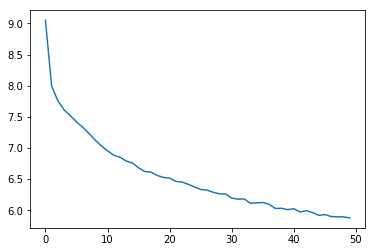

In [30]:
import matplotlib.pyplot as plt
plt.plot(np.log(history.history["head_boxes_loss"]))
#plt.plot(np.log(history.history["head_classes_loss"]))
#plt.plot(np.log(history.history["loss"]))
plt.show();

### Displaying images and bounding box

In order to display our annotations, we build the function `plot_annotations` as follows:
- display the image
- display on top annotations and ground truth bounding boxes and classes

The `display` function:
- takes a single index and computes the result of the model
- interpret the output of the model as a bounding box
- calls the `plot_annotations` function

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt

def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    #axis.text(bbox[0], bbox[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
def plot_annotations(img_path, annotation=None, ground_truth=None):
    img = imread(img_path)
    plt.imshow(img)
    current_axis = plt.gca()
    if ground_truth:
        text = "gt " + ground_truth["class"]
        patch(current_axis, ground_truth["bbox"], text, "red")
    if annotation:
        conf = '{:0.2f} '.format(annotation['confidence'])
        text = conf + annotation["class"]
        patch(current_axis, annotation["bbox"], text, "blue")
    #plt.axis('off')
    plt.show()

def display(index, ground_truth=True):
    res = model.predict(reprs[index][np.newaxis,])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations("VOCdevkit/VOC2007/JPEGImages/" + annotations[index]["filename"], 
                     output, annotations[index] if ground_truth else None)

Let's display the predictions of the model and the ground truth annotation for a couple of images in our tiny debugging training set:

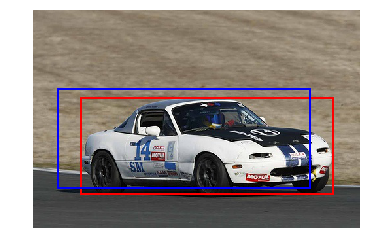

In [42]:
display(1024)

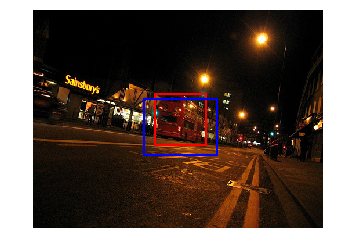

In [43]:
display(1069)

### Predict bounding box of new images

(640, 586, 3)


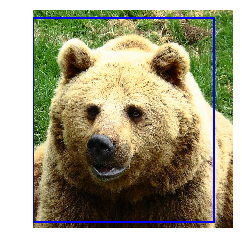

{'bbox': [0, 23, 531, 621], 'class': 'dog', 'confidence': 0.97018528}
[array([[  9.70185280e-01,   2.77074520e-02,   1.29210122e-03,
          8.13207822e-04,   2.00383124e-06]], dtype=float32), array([[  97.32050323,  112.88393402,  211.51306152,  209.33444214]], dtype=float32)]


In [44]:
ImgR = predict_batch(headless_conv, ["COCO_val2014_000000000285.jpg"], (224, 224))
res = model.predict(ImgR)
a=imread("COCO_val2014_000000000285.jpg")
print(a.shape)
output = interpret_output(res[0][0], res[1][0],(a.shape[1],a.shape[0]))
plot_annotations("COCO_val2014_000000000285.jpg", output)
#print(ImgR)
print(output)
print(res)

(500, 375, 3)


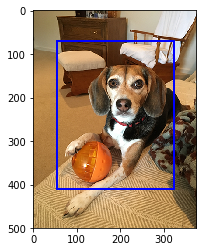

{'bbox': [55, 70, 323, 410], 'class': 'dog', 'confidence': 0.99906939}


In [173]:
ImgR = predict_batch(headless_conv, ["dog_beagle.png"], (224, 224))
res = model.predict(ImgR)
a=imread("dog_beagle.png")
print(a.shape)
output = interpret_output(res[0][0], res[1][0],(a.shape[1],a.shape[0]))
plot_annotations("dog_beagle.png", output)
print(output)

55 323 70 410
(500, 375, 3)


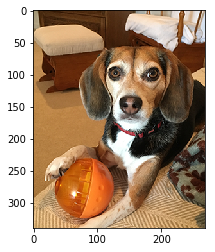

In [174]:
from scipy import misc
a=misc.imread("dog_beagle.png")
x1=output['bbox'][0]
x2=output['bbox'][2]
y1=output['bbox'][1]
y2=output['bbox'][3]
print(x1,x2,y1,y2)
print(a.shape)
a=a[y1:y2,x1:x2]

#a=imresize(a,(224,224))
plt.imshow(a)
plt.show()

In [60]:
FEmodel = ResNet50(weights='imagenet', include_top=False)

In [175]:
from keras.preprocessing import image
a = image.img_to_array(a)
a = np.expand_dims(a, axis=0)
a = preprocess_input(a)
feature=FEmodel.predict(a)
print(feature[0][0][0].shape)

(2048,)


(580, 640, 3)
{'bbox': [105, 167, 480, 436], 'class': 'dog', 'confidence': 0.59154534}


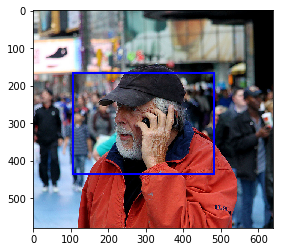

In [186]:
#COCO_val2014_000000000395.jpg
path='val2014/COCO_val2014_000000000395.jpg'
ImgR = predict_batch(headless_conv, [path], (224, 224))
res = model.predict(ImgR)
a=imread(path)
print(a.shape)
output = interpret_output(res[0][0], res[1][0],(a.shape[1],a.shape[0]))
print(output)
plot_annotations(path, output)

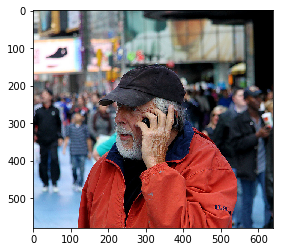

105 480 167 436
3


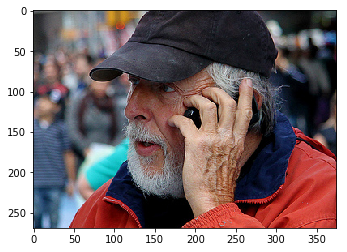

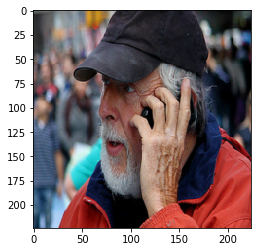

In [187]:
from scipy import misc
a=misc.imread(path)
plt.imshow(a)
plt.show()
x1=output['bbox'][0]
x2=output['bbox'][2]
y1=output['bbox'][1]
y2=output['bbox'][3]
print(x1,x2,y1,y2)
print(len(a.shape))
a=a[y1:y2,x1:x2]
plt.imshow(a)
plt.show()
a=imresize(a,(224,224))
plt.imshow(a)
plt.show()

## Feature extraction of the bounding box region

In [176]:
from scipy import misc
from keras.preprocessing import image

FEmodel = ResNet50(weights='imagenet', include_top=False)
out=open("out_id.txt",'r')
img_rep=open("img_rep.txt",'w')
#print (len(out))
features=[]
text=out.readlines()
m=0

for id_num in text:
    m=m+1
    print(m)
    #id_num=out.readline()
    #COCO_val2014_000000000042
    pre="COCO_val2014_"
    idx=id_num[:-1]
    num0=12-len(idx)
    zero=""
    for i in range(0,num0):
        zero+="0"
    
    idx=pre+zero+idx+".jpg"
    img_path="val2014/"+idx
    print(img_path)
    a=imread(img_path)
    if len(a.shape)!=3:
        features.append([0]*2048)
        continue
    ImgR = predict_batch(headless_conv, [img_path], (224, 224))
    res = model.predict(ImgR)
    output = interpret_output(res[0][0], res[1][0],(a.shape[1],a.shape[0]))
    #print(output)
    
    x1=output['bbox'][0]
    x2=output['bbox'][2]
    y1=output['bbox'][1]
    y2=output['bbox'][3]
    #print(x1,x2,y1,y2)
    #print(a.shape)
    if y2<=y1 or x2<=x1:
        features.append([0]*2048)
        continue
    a=a[y1:y2,x1:x2]
    a=imresize(a,(224,224))
    a = image.img_to_array(a)
    a = np.expand_dims(a, axis=0)
    a = preprocess_input(a)
    feature = FEmodel.predict(a)
    #print (feature)
    #img_rep.write(str(feature)+'\n')
    features.append(feature[0][0][0])
    #print (features)
    
out.close()
img_rep.close()

1
val2014/COCO_val2014_000000000042.jpg
2
val2014/COCO_val2014_000000000285.jpg
3
val2014/COCO_val2014_000000000472.jpg
4
val2014/COCO_val2014_000000000502.jpg
5
val2014/COCO_val2014_000000000636.jpg
6
val2014/COCO_val2014_000000000827.jpg
7
val2014/COCO_val2014_000000000873.jpg
8
val2014/COCO_val2014_000000001029.jpg
9
val2014/COCO_val2014_000000001063.jpg
10
val2014/COCO_val2014_000000001205.jpg
11
val2014/COCO_val2014_000000001340.jpg
12
val2014/COCO_val2014_000000001442.jpg
13
val2014/COCO_val2014_000000001448.jpg
14
val2014/COCO_val2014_000000001464.jpg
15
val2014/COCO_val2014_000000001525.jpg
16
val2014/COCO_val2014_000000001647.jpg
17
val2014/COCO_val2014_000000001739.jpg
18
val2014/COCO_val2014_000000001852.jpg
19
val2014/COCO_val2014_000000002061.jpg
20
val2014/COCO_val2014_000000002255.jpg
21
val2014/COCO_val2014_000000002495.jpg
22
val2014/COCO_val2014_000000002521.jpg
23
val2014/COCO_val2014_000000003084.jpg
24
val2014/COCO_val2014_000000003217.jpg
25
val2014/COCO_val2014_0

In [178]:
# confirm image number
print(len(features))

4857


In [179]:
#transfer it to numpyarray
f=np.array(features)

## K-means clustering

In [180]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=85,random_state=0).fit(f)

In [181]:
a=kmeans.labels_

In [182]:
a.shape

(4857,)

In [183]:
outf=open("cluster.txt","w")
for x in a:
    outf.write(str(x)+"\n")
outf.close()

In [184]:
np.save('outf',f)

In [185]:
np.save('outa',a)